In [1]:
import requests
import os 

from config import config

CHAT_PDF_API = config.CHAT_PDF_API

# Upload file

In [ ]:
files = [
    ('file', ('file', open('./data/aon.pdf', 'rb'), 'application/octet-stream'))
]
headers = {
    'x-api-key': f'{CHAT_PDF_API}'
}

response = requests.post(
    'https://api.chatpdf.com/v1/sources/add-file', headers=headers, files=files)

if response.status_code == 200:
    print('Source ID:', response.json()['sourceId'])
    source_id = response.json()['sourceId']
else:
    print('Status:', response.status_code)
    print('Error:', response.text)

# Ask Questions

In [ ]:
headers = {
    'x-api-key': f'{CHAT_PDF_API}',
    "Content-Type": "application/json",
}

data = {
    "referenceSources": True,
    'sourceId': f"{source_id}",
    'messages': [
        {
            'role': "user",
            'content': "Summarise the Global insurance Q1 market dynamics pricing.",
        }
    ]
}

response = requests.post(
    'https://api.chatpdf.com/v1/chats/message', headers=headers, json=data)

if response.status_code == 200:
    print('Result:', response.json()['content'])
    print('Result:', response.json()['references'])
else:
    print('Status:', response.status_code)
    print('Error:', response.text)

# Delete PDF

In [ ]:
headers = {
  'x-api-key': f'{CHAT_PDF_API}',
  'Content-Type': 'application/json',
}

data = {
  'sources': [f'{source_id}'],
}

try:
  response = requests.post(
    'https://api.chatpdf.com/v1/sources/delete', json=data, headers=headers)
  response.raise_for_status()
  print('Success - pdf deleted')
except requests.exceptions.RequestException as error:
  print('Error:', error)
  print('Response:', error.response.text)

# Custom Version ---

#### curl -O https://gpt4all.io/models/ggml-gpt4all-j-v1.3-groovy.bin

In [4]:
from langchain.chains import RetrievalQA
from langchain.document_loaders import PyPDFLoader
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.llms import GPT4All
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import Chroma
from langchain import HuggingFaceHub
from pdf2image import convert_from_path

In [98]:
pdf_file = "/Users/nickaristidou/Downloads/alex_test.pdf"
pdf_file2 = "./data/hiscox.pdf"

In [99]:
images = convert_from_path(pdf_file, dpi=88)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [121]:
loader = PyPDFLoader(file_path=pdf_file)
documents = loader.load_and_split()
len(documents)

130

In [122]:
loader2 = PyPDFLoader(file_path=pdf_file2)
documents2 = loader2.load_and_split()
len(documents2)

119

In [102]:
print(documents[24].page_content)

As noted above, the Commission expressed the view in the Proposing Release that the 
financial and regulatory risk mana gement controls and supervisory procedures described in the 
proposed rule should apply broadly to all form s of market access by br oker-dealers that are 
exchange members or ATS subscribers, including sponsored access, direct market access, and 
more traditional agency brokerage arrangements with customers, as well as proprietary trading.49  
Accordingly, the proposed term “market a ccess” includes all such activities.   
Certain commenters suggested that the scope of the proposed rule is too far-reaching in 
that it encompasses broker-dealer activities that do not raise risks as significant as those that 
occur in “unfiltered” sponsored access arrangements.50  One commenter believed that the 
proposed rule would lead to duplicative, unnecessary, and costly regulation.51  Another 
commenter, while acknowledging the risks pose d by unfiltered sponsored access arrange

In [123]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1024, chunk_overlap=64)
texts = text_splitter.split_documents(documents)
len(texts)

357

In [124]:
texts2 = text_splitter.split_documents(documents2)
len(texts2)

349

In [130]:
texts_total = texts + texts2

## Create embeddings

In [131]:
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

In [132]:
db = Chroma.from_documents(texts_total, embeddings, persist_directory="chroma")

## Create Chain

In [71]:
model_n_ctx = 1000
model_path = "./ggml-gpt4all-j-v1.3-groovy.bin"
llm = GPT4All(model=model_path, backend="gptj", verbose=False)

Found model file at  ./ggml-gpt4all-j-v1.3-groovy.bin
gptj_model_load: loading model from './ggml-gpt4all-j-v1.3-groovy.bin' - please wait ...
gptj_model_load: n_vocab = 50400
gptj_model_load: n_ctx   = 2048
gptj_model_load: n_embd  = 4096
gptj_model_load: n_head  = 16
gptj_model_load: n_layer = 28
gptj_model_load: n_rot   = 64
gptj_model_load: f16     = 2
gptj_model_load: ggml ctx size = 5401.45 MB
gptj_model_load: kv self size  =  896.00 MB
gptj_model_load: ................................... done
gptj_model_load: model size =  3609.38 MB / num tensors = 285


In [13]:
# os.environ["HUGGINGFACEHUB_API_TOKEN"] = config.HF_API

# llm = HuggingFaceHub(
#     repo_id="tiiuae/falcon-7b-instruct",
#     model_kwargs={
#         "temperature":1
#     }
# )

In [133]:
qa = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=db.as_retriever(search_kwargs={"k": 3}),
    return_source_documents=True,
    verbose=False,
)

## Ask questions

In [134]:
%%time
res = qa(
    "Give me a summary of transaction reporting for mifid? extract the reponse from the text."
)

CPU times: user 3min 47s, sys: 783 ms, total: 3min 48s
Wall time: 57.7 s


In [135]:
print(res)

{'query': 'Give me a summary of transaction reporting for mifid? extract the reponse from the text.', 'result': " The Commission expects that brokers and dealers with market access will be able to identify customers associated with post-trade execution reports resulting from their transactions, which can help them investigate potential regulatory violations or suspicious trading activity. Brokers and dealers must also ensure that appropriate surveillance personnel receive immediate post-trade execution reports related to these transactions in order for the broker/dealer's risk management controls and procedures to be effective. The Commission believes that this requirement will provide valuable information about financial exposure, supplementing systematic pre-trade risk control measures and other supervision procedures.", 'source_documents': [Document(page_content='Finally, Rule 15c3-5(c)(2)(iv) wi ll require the broker-dealer’s controls and procedures to \nassure that appropriate sur

In [136]:
print(res["result"])

 The Commission expects that brokers and dealers with market access will be able to identify customers associated with post-trade execution reports resulting from their transactions, which can help them investigate potential regulatory violations or suspicious trading activity. Brokers and dealers must also ensure that appropriate surveillance personnel receive immediate post-trade execution reports related to these transactions in order for the broker/dealer's risk management controls and procedures to be effective. The Commission believes that this requirement will provide valuable information about financial exposure, supplementing systematic pre-trade risk control measures and other supervision procedures.


In [137]:
for ref in range(0, len(res["source_documents"])):
    print(res["source_documents"][ref].metadata["page"])

47
15
76


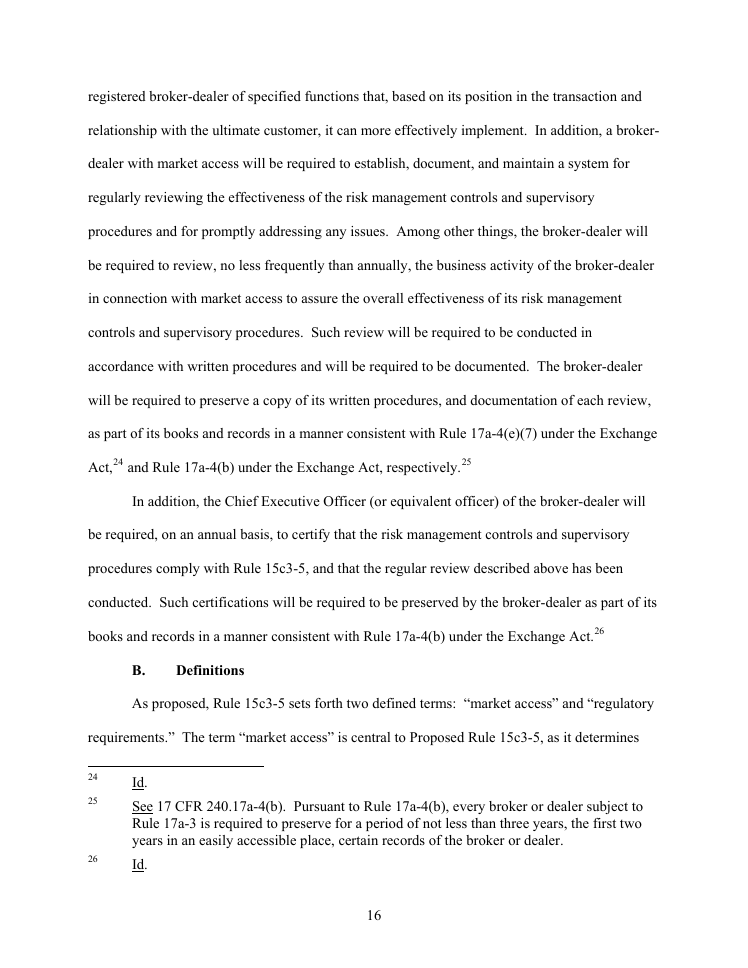

In [138]:
images[15]

# Ask question about 2nd pdf

In [153]:
res_2 = qa(
    "What were the profits for syndicate 33 in 2022? extract the reponse from the text."
)

In [154]:
print(res_2)

{'query': 'What were the profits for syndicate 33 in 2022? extract the reponse from the text.', 'result': ' The result for Syndicate 33 in calendar year 2022 is a profit of $194.3 million (2021: profit of $193.8 million). While profit is materially in line with the prior year, the improved combined ratio of 77% demonstrates further improvement in underwriting results where the Syndicate has continued to take advantage of rate rises and recent underwriting actions are taking effect. The result was impacted by foreign exchange losses and bond market delivering mark-to-market investment losses.', 'source_documents': [Document(page_content='The result for Syndicate 33 in calendar year 2022 is a profit  \nof $194.3 million (2021: profit of $193.8 million). While profit  \nis materially in line with the prior year, the improved combined \nratio of 77% (2021: 83%) demonstrates further improvement \nin underwriting results, where the Syndicate has continued to \ntake advantage of rate rises an

In [155]:
res_2["result"]

' The result for Syndicate 33 in calendar year 2022 is a profit of $194.3 million (2021: profit of $193.8 million). While profit is materially in line with the prior year, the improved combined ratio of 77% demonstrates further improvement in underwriting results where the Syndicate has continued to take advantage of rate rises and recent underwriting actions are taking effect. The result was impacted by foreign exchange losses and bond market delivering mark-to-market investment losses.'

In [156]:
res_2["source_documents"]

[Document(page_content='The result for Syndicate 33 in calendar year 2022 is a profit  \nof $194.3 million (2021: profit of $193.8 million). While profit  \nis materially in line with the prior year, the improved combined \nratio of 77% (2021: 83%) demonstrates further improvement \nin underwriting results, where the Syndicate has continued to \ntake advantage of rate rises and recent underwriting actions \nare taking effect. The Syndicate has weathered Hurricane  \nIan and losses arising from the Russia/Ukraine conflict during  \n2022, and benefitted from strong favourable development  \non prior-year losses. The result was, however, impacted by  \nforeign exchange losses and the bond market delivering  \nmark-to-market investment losses.\nThe Syndicate’s key financial performance indicators during  \nthe year were as follows:\n2022\n$m2021\n$m%\nchange\nGross premiums written 2,072.3 2,056.1 0.8\nGross premiums earned 2,046.4 2,039.9 0.3\nNet premiums earned 1,174.6 1,099.0 6.9\nTota

In [159]:
test = qa(
    "From page 5 of the hiscox report what was the Gross premiums written in 2022? extract the reponse from the text."
)

In [158]:
test["result"]

' The gross premiums written by Grossel & Co Ltd for the financial year ending 31 December 2021 is not provided on this document, but it can be estimated based on information given about their total premium income and net claims paid during that period (page 10).'